In [1]:
import requests
import pandas as pd

# Set the Open-Meteo API endpoint and your parameters (e.g., daily weather variables)
url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": -6.1818,  # Example latitude for Jakarta
    "longitude": 106.8223,  # Example longitude for Jakarta
    "daily": "temperature_2m_max,temperature_2m_min",  # Daily max and min temperatures
    "start_date": "2024-11-18",  # Start date
    "end_date": "2024-11-24",    # End date
    "timezone": "auto"           # Automatically adjusts to the local timezone
}

# Fetch data from Open-Meteo
response = requests.get(url, params=params)
data = response.json()

# Extract the daily temperature data
dates = data['daily']['time']
temp_max = data['daily']['temperature_2m_max']
temp_min = data['daily']['temperature_2m_min']

# Create a DataFrame
df = pd.DataFrame({
    'date': dates,
    'temp_max': temp_max,
    'temp_min': temp_min
})

print(df.head())


         date  temp_max  temp_min
0  2024-11-18      31.8      26.1
1  2024-11-19      33.9      25.8
2  2024-11-20      32.6      26.0
3  2024-11-21      32.9      26.0
4  2024-11-22      33.7      25.9


In [2]:
# Ensure 'date' is in datetime format
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Combine temp_max and temp_min into an average temperature (optional)
df['temp_avg'] = (df['temp_max'] + df['temp_min']) / 2

print(df.head())


            temp_max  temp_min  temp_avg
date                                    
2024-11-18      31.8      26.1     28.95
2024-11-19      33.9      25.8     29.85
2024-11-20      32.6      26.0     29.30
2024-11-21      32.9      26.0     29.45
2024-11-22      33.7      25.9     29.80


In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

# Prepare features (e.g., lag values) and labels
df['temp_avg_lag1'] = df['temp_avg'].shift(1)  # Create lag features
df.dropna(inplace=True)

X = df[['temp_avg_lag1']]  # Use lagged temperature as input
y = df['temp_avg']         # Predict the next day's average temperature

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Forecast for the test set
forecast = model.predict(X_test)

# Display predictions
df_forecast = pd.DataFrame({
    'actual': y_test,
    'predicted': forecast
}, index=X_test.index)
print(df_forecast.head())


            actual  predicted
date                         
2024-11-19   29.85    29.6110
2024-11-20   29.30    30.1355


In [14]:
# Predict the next 7 days
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=7)
future_temps = []

last_temp = df['temp_avg'].iloc[-1]

for _ in range(7):
    next_temp = model.predict(np.array([[last_temp]]))[0]
    future_temps.append(next_temp)
    last_temp = next_temp

df_future = pd.DataFrame({
    'date': future_dates,
    'predicted_temp': future_temps
})
print(df_future)


        date  predicted_temp
0 2024-11-25         30.2885
1 2024-11-26         30.2885
2 2024-11-27         30.2885
3 2024-11-28         30.2885
4 2024-11-29         30.2885
5 2024-11-30         30.2885
6 2024-12-01         30.2885


c:\Users\internship.ictapps2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\internship.ictapps2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\internship.ictapps2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\internship.ictapps2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\internship.ictapps2\AppData\Local\Programs\Python\Python313\Lib\sit

In [5]:
# Check for extreme conditions and automate alerts
for _, row in df_future.iterrows():
    if row['predicted_temp'] > 30:  # Example: High temperature threshold
        print(f"Alert: High temperature on {row['date']:%Y-%m-%d}. Predicted temp: {row['predicted_temp']:.2f}°C")
    elif row['predicted_temp'] < 20:  # Example: Low temperature threshold
        print(f"Alert: Low temperature on {row['date']:%Y-%m-%d}. Predicted temp: {row['predicted_temp']:.2f}°C")


Alert: High temperature on 2024-11-25. Predicted temp: 30.29°C
Alert: High temperature on 2024-11-26. Predicted temp: 30.29°C
Alert: High temperature on 2024-11-27. Predicted temp: 30.29°C
Alert: High temperature on 2024-11-28. Predicted temp: 30.29°C
Alert: High temperature on 2024-11-29. Predicted temp: 30.29°C
Alert: High temperature on 2024-11-30. Predicted temp: 30.29°C
Alert: High temperature on 2024-12-01. Predicted temp: 30.29°C


In [18]:
# import schedule
# import time

# def fetch_and_forecast():
#     # Step 1: Fetch data (reuse your Open-Meteo code)
#     # Step 2: Process and forecast (reuse the forecasting code)
#     print("Weather data fetched and forecast completed.")

# # Schedule the task daily at a specific time (e.g., 8:00 AM)
# schedule.every().day.at("08:00").do(fetch_and_forecast)

# while True:
#     schedule.run_pending()
#     time.sleep(1)


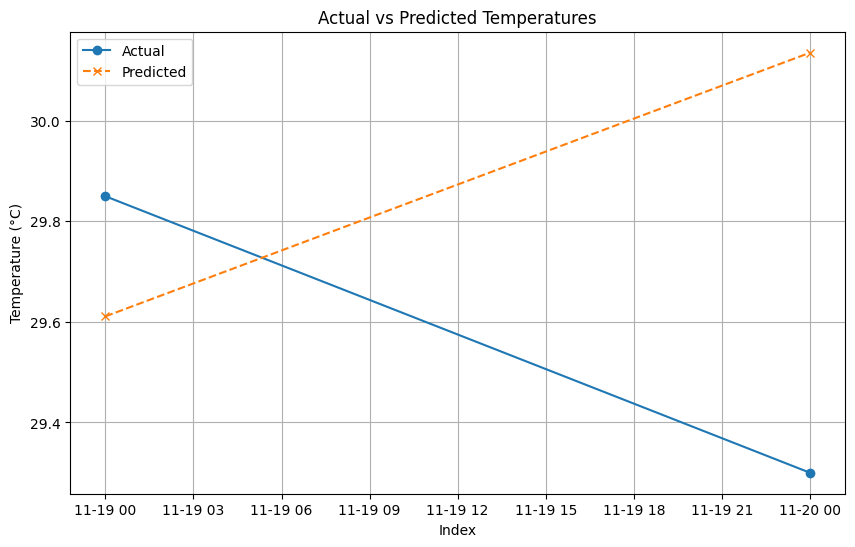

In [17]:
import matplotlib.pyplot as plt

# Sort the DataFrame by the index to maintain temporal order
df_forecast = df_forecast.sort_index()

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(df_forecast.index, df_forecast['actual'], label='Actual', marker='o')
plt.plot(df_forecast.index, df_forecast['predicted'], label='Predicted', marker='x', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperatures')
plt.legend()
plt.grid()
plt.show()


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(df_forecast['actual'], df_forecast['predicted'])
mse = mean_squared_error(df_forecast['actual'], df_forecast['predicted'])
r2 = r2_score(df_forecast['actual'], df_forecast['predicted'])

print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}")


MAE: 0.54, MSE: 0.38, R²: -3.99
